In [179]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras import layers, models
from keras.callbacks import EarlyStopping

In [196]:
input_dataset_path = 'drive/MyDrive/Collab-Datasets/nasd_input.csv'
query_dataset_path = 'drive/MyDrive/Collab-Datasets/nasd_query.csv'
DATASET_SIZE = 1
LAG = 15

In [197]:
timeseries_df = pd.read_csv(input_dataset_path, sep='\t', index_col=0, header=None).astype(np.float32).sample(DATASET_SIZE)
TIME_SERIES_ID = timeseries_df.index.tolist()

In [198]:
mu = None
sigma = None
def normalize(dataset):
  return (dataset - mu)/sigma 

def reverse_normalize(dataset):
  return dataset*sigma + mu 

def preprocess_dataset(df, lag=1):
  global sigma
  global mu
  dataset = df.to_numpy()
  
  if sigma is None: sigma = dataset.std()
  if mu is None: mu = dataset.mean()

  dataset = normalize(dataset)
  # divide the time series in input instances of X: #lag steps y: #lag+1-th value of the time series 
  # so we acquire #df * (complexity(df)-lag)
  X = None
  y = None
  for timeseries in dataset:
    for i in range(lag, len(timeseries)):
      X_i = np.asarray(timeseries[i-lag:i]).reshape((1, len(timeseries[i-lag:i]), 1))
      X = np.concatenate((X, X_i)) if X is not None else X_i
      y_i = np.asarray(timeseries[i]).reshape((-1))
      y = np.concatenate((y, y_i)) if y is not None else y_i
  return train_test_split(X, y, test_size=0.2)

In [199]:
X_train, X_val, y_train, y_val = preprocess_dataset(timeseries_df, lag=LAG)

In [200]:
class TimeSeriesForecast():
  def __init__(self, input_dim, lstm_units, dropout=None, _optimizer='adam', _loss='mse'):
    self.history = {}
    self.D_train = None
    self.D_test = None
    self.lstm_units = lstm_units
    self.dropout = dropout
    self.optimizer = _optimizer
    self.loss = _loss
    self.input_dim = input_dim
    self.models = {}
  

  def create_model(self, time_series_id):
    # create the model architecture
    model = models.Sequential()
    for i, u in enumerate(self.lstm_units):
      if i == 0: 
        model.add(layers.LSTM(units=u, return_sequences=True, input_shape=self.input_dim))
      elif i == len(self.lstm_units) - 1:
        model.add(layers.LSTM(units=u))
      else: 
        model.add(layers.LSTM(units=u, return_sequences=True))
      if self.dropout is not None:
        model.add(layers.Dropout(self.dropout))

    # final output layer
    model.add(layers.Dense(1))
    
    model.compile(optimizer=self.optimizer, loss=self.loss)
    
    self.models[time_series_id] = model

  def fit(self, time_series_id, X, y, epochs=100, batch_size=128):
    if time_series_id not in self.models:
      self.create_model(time_series_id)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    self.D_train = X_train, y_train
    self.D_test = X_test, y_test
    self.history[time_series_id] = self.models[time_series_id].fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1)
    return self.history[time_series_id]

  def predict(self, time_series_id, X):
    return self.models[time_series_id].predict(X)

  def evaluate(self, time_series_id, X, y_true):
    return self.models[time_series_id].evaluate(X, y_true, batch_size=64)

In [201]:
model = TimeSeriesForecast(X_train.shape[1:], [50, 50,100, 200], dropout=0.5)

In [202]:
model.fit(TIME_SERIES_ID[0], X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
12/12 [==============================] - 9s 186ms/step - loss: 0.4066 - val_loss: 0.1394
Epoch 2/50
12/12 [==============================] - 0s 31ms/step - loss: 0.1397 - val_loss: 0.0828
Epoch 3/50
12/12 [==============================] - 0s 31ms/step - loss: 0.0754 - val_loss: 0.0523
Epoch 4/50
12/12 [==============================] - 0s 31ms/step - loss: 0.0703 - val_loss: 0.0471
Epoch 5/50
12/12 [==============================] - 0s 32ms/step - loss: 0.0674 - val_loss: 0.0462
Epoch 6/50
12/12 [==============================] - 0s 30ms/step - loss: 0.0810 - val_loss: 0.0452
Epoch 7/50
12/12 [==============================] - 0s 32ms/step - loss: 0.0644 - val_loss: 0.0591
Epoch 8/50
12/12 [==============================] - 0s 31ms/step - loss: 0.0708 - val_loss: 0.0429
Epoch 9/50
12/12 [==============================] - 0s 31ms/step - loss: 0.0710 - val_loss: 0.0431
Epoch 10/50
12/12 [==============================] - 0s 32ms/step - loss: 0.0738 - val_loss: 0.0448
Epoch 11

In [203]:
model.evaluate(TIME_SERIES_ID[0], X_val, y_val) 

3/3 [==============================] - 0s 10ms/step - loss: 0.0293


0.029322050511837006

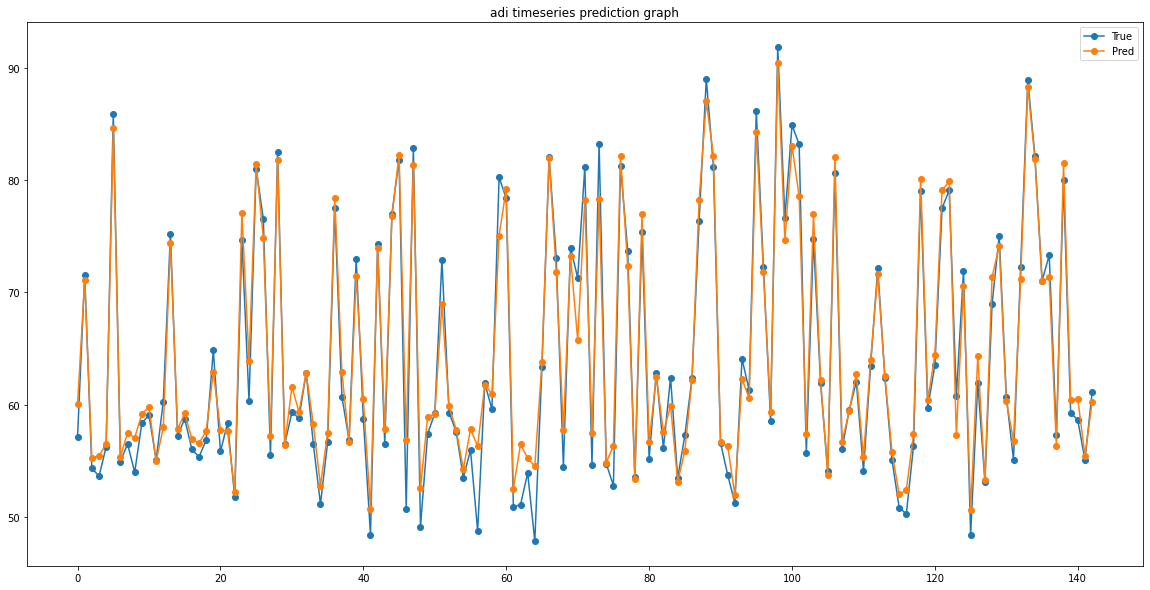

In [204]:
y_pred = reverse_normalize(model.predict(TIME_SERIES_ID[0], X_val))
figure(figsize=(20, 10))
plt.plot(np.arange(0, len(y_val)), reverse_normalize(y_val) ,'o-', np.arange(0, len(y_val)), y_pred, 'o-')
plt.legend(['True', "Pred"])
plt.title(f"{TIME_SERIES_ID[0]} timeseries prediction graph")
plt.show()